## Google drive amount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

In [ ]:
!pip install tensorboard --upgrade
!pip install --upgrade tensorflow

#Import requirements

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from keras.initializers import glorot_uniform
from keras.metrics import categorical_accuracy,top_k_categorical_accuracy
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop
from keras.models import Model

import cv2
import os
import datetime

## Loading data and preprocessing

In [3]:
import cv2
import numpy as np
import os

labels = ['PNEUMONIA', 'NORMAL']
img_size = 180

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None and img_arr.shape[0] > 0 and img_arr.shape[1] > 0:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
                else:
                    print(f"Skipping image: {os.path.join(path, img)}")
            except Exception as e:
                print(e)
    return np.array(data)

train_dir='/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/train'
val_dir='/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/test'
test_dir='/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/val'

train_normal_dir='/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/train/NORMAL'
train_pneumonia_dir='/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/train/PNEUMONIA'
val_normal_dir='/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/val/NORMAL'
val_pneumonia_dir='/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/val/PNEUMONIA'

train = get_training_data('/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/val')

Skipping image: /content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
Skipping image: /content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/train/NORMAL/.DS_Store


<ipython-input-3-77e035a7fc18>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Skipping image: /content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
Skipping image: /content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/val/NORMAL/.DS_Store


Text(0.5, 1.0, 'NORMAL')

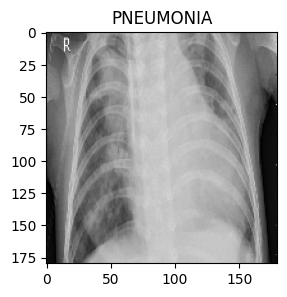

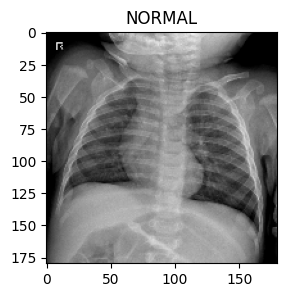

In [4]:
plt.figure(figsize = (3,3))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (3,3))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

## Normalization and Data augmentation

In [6]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [7]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [8]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


val_datagen2=ImageDataGenerator(rescale=1.0/255)

test_datagen2=ImageDataGenerator(rescale=1.0/255)

train_generator2=datagen.flow_from_directory(train_dir,target_size=(180,180),batch_size=128,class_mode='binary')

val_generator2=val_datagen2.flow_from_directory(val_dir,target_size=(180,180),batch_size=128,class_mode='binary')

test_generator2=test_datagen2.flow_from_directory(test_dir,target_size=(180,180),batch_size=128,class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Tensorboard callbacks


In [14]:
import tensorflow as tf
import datetime

log_dir = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# TensorBoard callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Model setup

1.   Basic CNN based model
2.   ResNet50
3.   Inception V3



In [45]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 90, 90, 64)      

In [46]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [47]:
#history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction]) #callbacks = [tensorboard_callback]

In [48]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir), learning_rate_reduction]

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=20,
                    validation_data=datagen.flow(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/20
163/163 [==============================] - 17s 79ms/step - loss: 0.6198 - accuracy: 0.8405 - val_loss: 1.3603 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 15s 94ms/step - loss: 0.2687 - accuracy: 0.8907 - val_loss: 7.3136 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9145
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 13s 82ms/step - loss: 0.2301 - accuracy: 0.9145 - val_loss: 40.5119 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 13s 76ms/step - loss: 0.1566 - accuracy: 0.9477 - val_loss: 32.9117 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/20
163/163 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9469
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [========================

## Tensorboard load for Colab

In [18]:
import datetime

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

%load_ext tensorboard

%tensorboard --logdir=/content/logs

!tensorboard dev upload --logdir /content/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-06-22 07:09:35.983918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
W0622 07:09:37.444061 139634506209024 plugin_event_accumulator.py:369] Found more than one graph event per run, or t

2023-06-22 07:09:40.609400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   SRRR-VZBB


Upload started and will continue reading any new data as it's added to the logdir.


In [17]:
%tensorboard --logdir {log_dir} --port=3000
#%tensorboard --logdir /content/drive/MyDrive/AIFFEL --port=3000

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-06-22 07:09:12.350544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())

In [23]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 13ms/step - loss: 0.3412 - accuracy: 0.8894
Loss of the model is -  0.3412404954433441
20/20 [==============================] - 0s 13ms/step - loss: 0.3412 - accuracy: 0.8894
Accuracy of the model is -  88.94230723381042 %


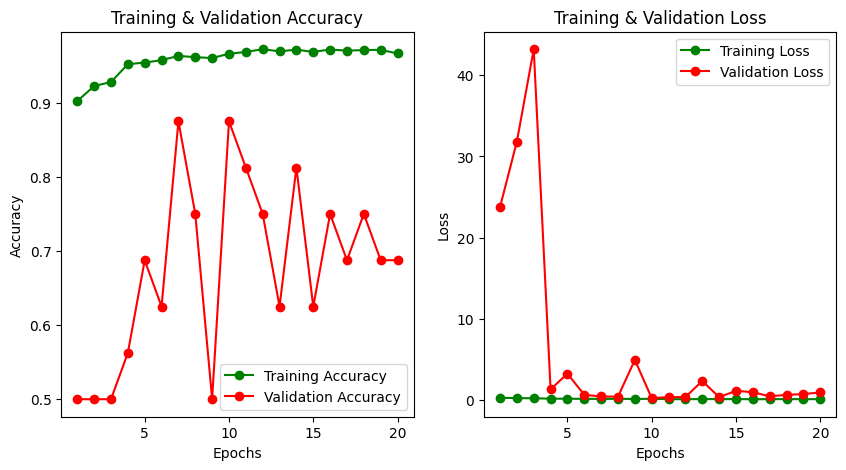

In [24]:
epochs = range(1, 21)  # Assuming history contains data for 20 epochs

fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(10, 5)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [25]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

20/20 [==============================] - 0s 12ms/step


In [26]:
threshold = 0.5  # Adjust the threshold as needed

binary_predictions = (predictions > threshold).astype(int)

print(classification_report(y_test, binary_predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.88      0.91       390
   Normal (Class 1)       0.82      0.91      0.86       234

           accuracy                           0.89       624
          macro avg       0.88      0.89      0.88       624
       weighted avg       0.89      0.89      0.89       624



In [27]:
cm = confusion_matrix(y_test, binary_predictions)
print(cm)

[[342  48]
 [ 21 213]]


<Axes: >

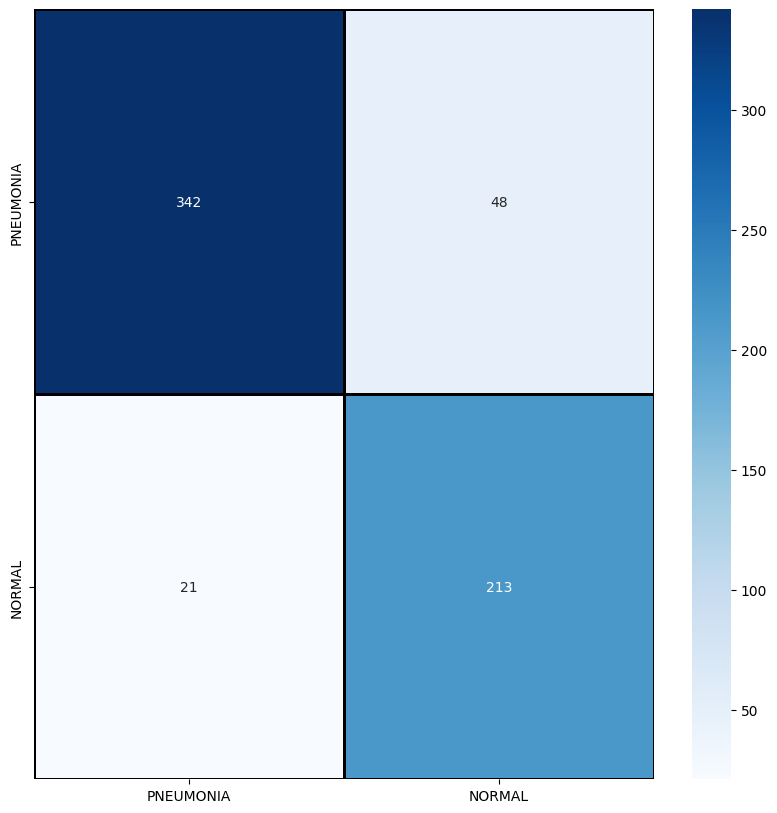

In [28]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [29]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<ipython-input-30-4e80237416e6>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


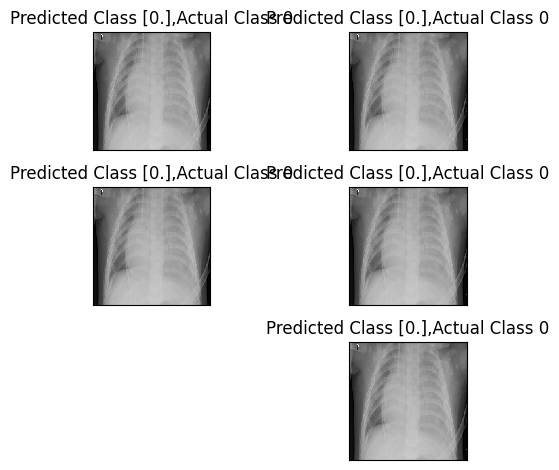

In [30]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(180,180), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-31-c631c9e4b6dd>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


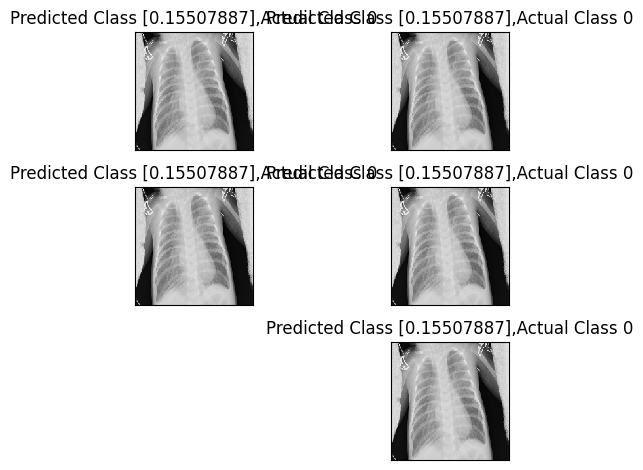

In [31]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(180,180), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### Generate cam


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

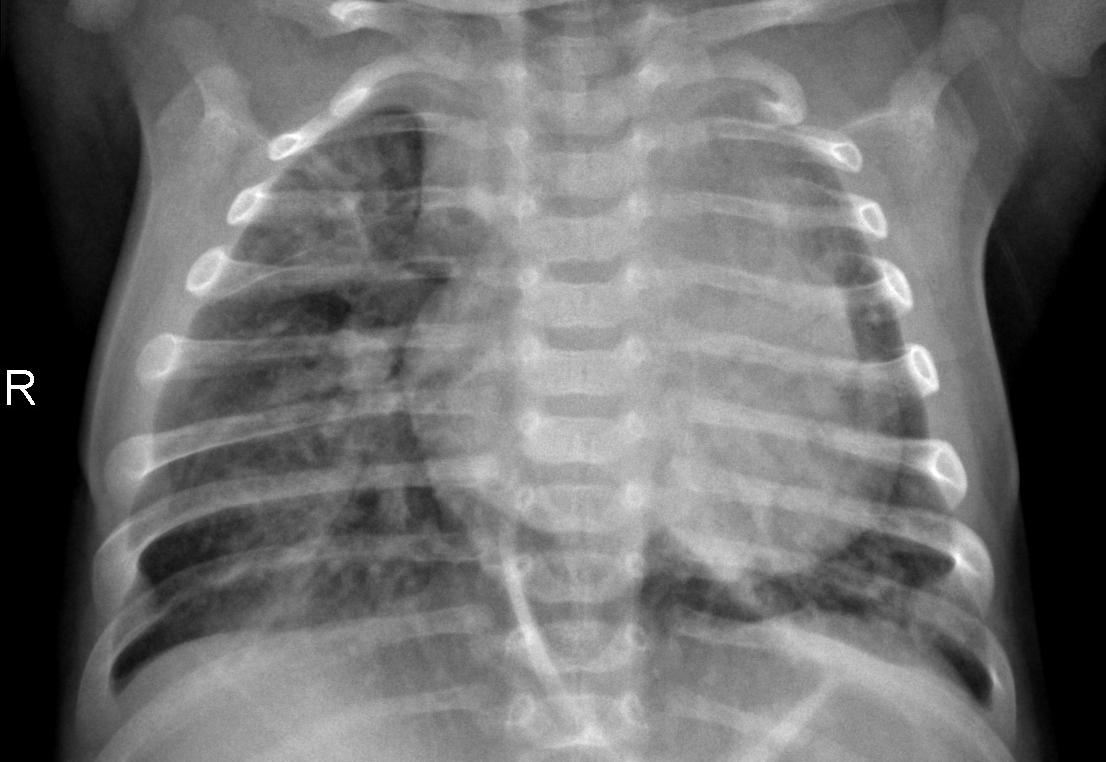

In [49]:
from PIL import Image

model_builder = keras.applications.xception.Xception
img_size = (180, 180)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_9 "

# The local path to our target image
img_path = '/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'

display(Image.open(img_path))

In [42]:
from keras import backend as K
image_path = '/content/drive/MyDrive/AIFFEL/main(1)/chest_xray/chest_xray/train/PNEUMONIA/person1086_virus_1798.jpeg'
class_index = 0  # Specify the index of the target class you want to visualize

In [50]:
def generate_cam(model, img_array, class_index):
    # Get the output of the last convolutional layer
    last_conv_layer = model.get_layer("conv2d_9")  # Modify the layer name as per your model

    # Create a model that outputs the feature maps and the predictions
    grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    # Compute the gradient of the predicted class with respect to the feature maps
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Generate the class activation map
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize the heatmap to the size of the input image
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    return heatmap

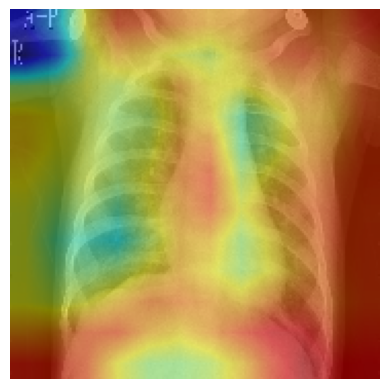

In [51]:
# Load the image and preprocess it
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180), color_mode='grayscale')
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the image

# Generate the class activation map
cam = generate_cam(model, img_array, class_index)

# Apply heatmap to the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = heatmap.astype(np.float32) / 255.0

# Blend the heatmap with the image
cam_img = cv2.addWeighted(cv2.cvtColor(img_array[0], cv2.COLOR_GRAY2BGR), 0.5, heatmap, 0.5, 0)

# Display the CAM image
plt.imshow(cam_img)
plt.axis('off')
plt.show()

### Pretrained inception v3

In [52]:
pretrained_model3=InceptionV3(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
#freazing the trained layers
for layers in pretrained_model3.layers:
    layers.trainable=False

In [53]:
last_layer=pretrained_model3.get_layer('mixed10')
last_output = last_layer.output

#### For tranfer learning

In [54]:
x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

model3=tf.keras.Model(pretrained_model3.input,x)

model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
# model4.summary()

In [ ]:
history3=model3.fit(train_generator2,validation_data=val_generator2,epochs=20,verbose=2,callbacks=callbacks)

#다 되됬는데

In [136]:
eval_result3 = model3.evaluate_generator(test_generator2, 624)
print('loss  :', eval_result3[0])
print('accuracy  :', eval_result3[1])
print('Precision :', eval_result3[2])
print('Recall :', eval_result3[3])

<ipython-input-136-6339a1669450>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  eval_result3 = model3.evaluate_generator(test_generator2, 624)


loss  : 0.2821655869483948
accuracy  : 0.9375
Precision : 0.8888888955116272
Recall : 1.0


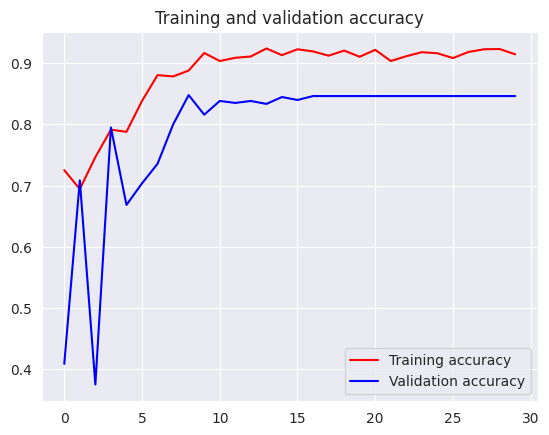

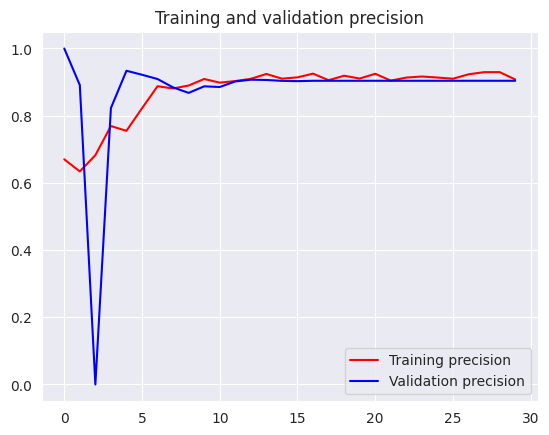

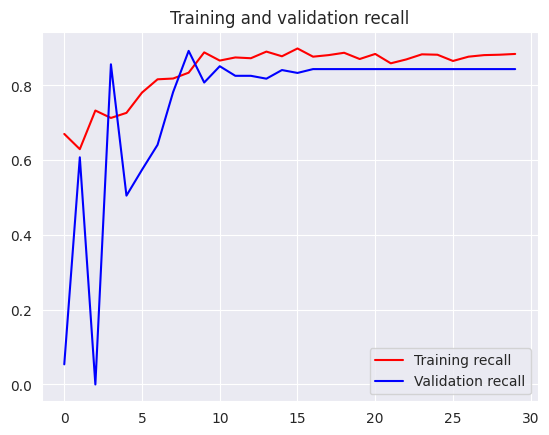

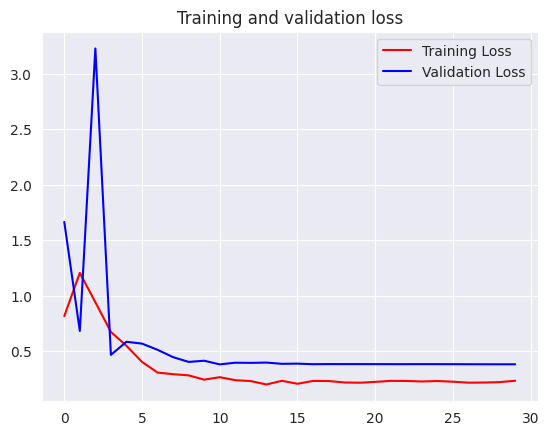

In [135]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

train_precision3=history3.history['precision']
val_precision3=history3.history['val_precision']

train_recall3=history3.history['recall']
val_recall3=history3.history['val_recall']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(len(acc3))

plt.plot(epochs, acc3, 'r', label='Training accuracy')
plt.plot(epochs, val_acc3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision3, 'r', label='Training precision')
plt.plot(epochs, val_precision3, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall3, 'r', label='Training recall')
plt.plot(epochs, val_recall3, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss3, 'r', label='Training Loss')
plt.plot(epochs, val_loss3, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### ResNet 50 for scratch

In [23]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [24]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [25]:
def ResNet50(input_shape = (64, 64, 3), classes = None):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [30]:
model2 = ResNet50(input_shape = (180,180,1), classes = 1)
model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model2.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 186, 186, 1)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 90, 90, 64)   3200        ['zero_padding2d_2[0][0]']       
                                                                                           

In [ ]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from keras.utils import to_categorical

# Convert the target labels to binary format
y_train = to_categorical(train_generator2.classes)
y_val = to_categorical(val_generator2.classes)

# Make sure to adjust the `classes` parameter when defining the model
model2 = ResNet50(input_shape=(180, 180, 1), classes=1)

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])

model2.summary()

history2 = model2.fit(train_generator2, validation_data=val_generator2, epochs=30, verbose=2, callbacks=callbacks)

#resnet 50은 시간이 너무 많이 걸려 다음에~